# Goal of the notebook
The main purpose of this notebook is to create regression model able to accuratelly  predcit `Take-Off Weight` of an aircraft based on some features.

## Note book structure
1. EDA
2. Modeling
3. Predictions (create save csv file with predictions in validatin set and alone as seperate csv)

### Description of columns in the dataset.
1. DepartureDate – date of departure
2. DepartureYear – year of departure
3. DepartureMonth – month of departure
4. DepartureDay – day of departure
5. FlightNumber – fight number
6. DepartureAirport – departure airport code
7. ArrivalAirport – arrival airport code
8. Route - route
9. ActualFlightTime – flight time
10. ActualTotalFuel – burnt fuel
11. ActualTOW - take-off weight (kg)
12. FlownPassengers – flown pax
13. BagsCount – flown bags
14. FlightBagsWeight – flown bags weight

In [82]:
!pip install feature-engine

In [83]:
!pip install xgboost


In [84]:
# Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PowerTransformer,FunctionTransformer
from feature_engine.imputation import MeanMedianImputer, AddMissingIndicator
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder, MeanEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from scipy.stats import randint, uniform



In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
full_train_data = pd.read_csv("/content/drive/MyDrive/Ryanair/training.csv",sep="\t")
val_data = pd.read_csv("/content/drive/MyDrive/Ryanair/validation.csv",sep="\t")

To protect data snooping bias, it is essential to devide training data set into tran, test, val sets

In [87]:
full_train_data

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016,175,61,440
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138,182,27,350
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447,127,(null),(null)
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587,163,12,150
4,01/10/2016,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090,178,37,490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,15/10/2016,2016,10,15,9833,PMI,HHN,PMI-HHN,102,4880,66247,177,96,1250
29727,15/10/2016,2016,10,15,9862,LPL,AGP,LPL-AGP,163,6890,67898,185,107,1390
29728,15/10/2016,2016,10,15,9863,AGP,LPL,AGP-LPL,145,6322,66247,172,64,830
29729,15/10/2016,2016,10,15,9948,FAO,ORK,FAO-ORK,132,5880,68224,183,82,1090


In [88]:
val_data

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,01/11/2016,2016,11,1,6003,MRS,BES,MRS-BES,84,3630,185,43,560
1,01/11/2016,2016,11,1,6004,BES,MRS,BES-MRS,86,3690,188,(null),(null)
2,01/11/2016,2016,11,1,6542,MRS,STN,MRS-STN,100,4390,168,55,720
3,01/11/2016,2016,11,1,6541,STN,MRS,STN-MRS,100,4690,185,35,460
4,01/11/2016,2016,11,1,5542,STN,REU,STN-REU,112,4900,167,31,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,01/11/2016,2016,11,1,2062,PMI,MAD,PMI-MAD,60,2775,173,12,160
1874,01/11/2016,2016,11,1,6423,BLQ,VLC,BLQ-VLC,99,4120,183,21,270
1875,01/11/2016,2016,11,1,6422,VLC,BLQ,VLC-BLQ,104,4230,182,31,400
1876,01/11/2016,2016,11,1,4316,BRI,BLQ,BRI-BLQ,59,2671,169,10,130


In [89]:
full_train_data.describe()

,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,ActualFlightTime,ActualTotalFuel
count,29731.0,29731.0,29731.000000,29731.000000,29731.000000,29731.000000
mean,2016.0,10.0,7.987723,4814.133934,110.069221,4782.483536
std,0.0,0.0,4.313351,3062.612334,52.457470,2069.865460
min,2016.0,10.0,1.000000,1.000000,2.000000,600.000000
25%,2016.0,10.0,4.000000,2087.000000,73.000000,3210.000000
50%,2016.0,10.0,8.000000,4765.000000,105.000000,4530.000000
75%,2016.0,10.0,12.000000,7496.000000,140.000000,6010.000000
max,2016.0,10.0,15.000000,9998.000000,1504.000000,17890.000000


In [90]:
full_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29731 entries, 0 to 29730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DepartureDate     29731 non-null  object
 1   DepartureYear     29731 non-null  int64 
 2   DepartureMonth    29731 non-null  int64 
 3   DepartureDay      29731 non-null  int64 
 4   FlightNumber      29731 non-null  int64 
 5   DepartureAirport  29731 non-null  object
 6   ArrivalAirport    29731 non-null  object
 7   Route             29731 non-null  object
 8   ActualFlightTime  29731 non-null  int64 
 9   ActualTotalFuel   29731 non-null  int64 
 10  ActualTOW         29731 non-null  object
 11  FLownPassengers   29731 non-null  object
 12  BagsCount         29731 non-null  object
 13  FlightBagsWeight  29731 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.2+ MB


In [91]:
full_train_data.isnull().sum()

,0
DepartureDate,0
DepartureYear,0
DepartureMonth,0
DepartureDay,0
FlightNumber,0
DepartureAirport,0
ArrivalAirport,0
Route,0
ActualFlightTime,0
ActualTotalFuel,0


There are no null values in dataset - but we can see some of the valeus are string `(null)` whitch corresponds to null value

## Data Cleaning

In [92]:
cols_to_clean = ['ActualTOW', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']

for col in cols_to_clean:
    full_train_data[col] = full_train_data[col].astype(str).str.strip()

for col in cols_to_clean:
  full_train_data[col] = full_train_data[col].replace("(null)",np.nan)
  full_train_data[col] = full_train_data[col].astype(float)


In [93]:
full_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29731 entries, 0 to 29730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DepartureDate     29731 non-null  object 
 1   DepartureYear     29731 non-null  int64  
 2   DepartureMonth    29731 non-null  int64  
 3   DepartureDay      29731 non-null  int64  
 4   FlightNumber      29731 non-null  int64  
 5   DepartureAirport  29731 non-null  object 
 6   ArrivalAirport    29731 non-null  object 
 7   Route             29731 non-null  object 
 8   ActualFlightTime  29731 non-null  int64  
 9   ActualTotalFuel   29731 non-null  int64  
 10  ActualTOW         29298 non-null  float64
 11  FLownPassengers   29636 non-null  float64
 12  BagsCount         27447 non-null  float64
 13  FlightBagsWeight  27253 non-null  float64
dtypes: float64(4), int64(6), object(4)
memory usage: 3.2+ MB


In [94]:
full_train_data.isna().sum()

,0
DepartureDate,0
DepartureYear,0
DepartureMonth,0
DepartureDay,0
FlightNumber,0
DepartureAirport,0
ArrivalAirport,0
Route,0
ActualFlightTime,0
ActualTotalFuel,0


In [95]:
# % of missing data
full_train_data.isna().sum()/len(full_train_data)*100

,0
DepartureDate,0.000000
DepartureYear,0.000000
DepartureMonth,0.000000
DepartureDay,0.000000
FlightNumber,0.000000
DepartureAirport,0.000000
ArrivalAirport,0.000000
Route,0.000000
ActualFlightTime,0.000000
ActualTotalFuel,0.000000


There are not much missing values, but there are some in out target - `ActualTOW`

# EDA

In [96]:
full_train_data

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0
4,01/10/2016,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,15/10/2016,2016,10,15,9833,PMI,HHN,PMI-HHN,102,4880,66247.0,177.0,96.0,1250.0
29727,15/10/2016,2016,10,15,9862,LPL,AGP,LPL-AGP,163,6890,67898.0,185.0,107.0,1390.0
29728,15/10/2016,2016,10,15,9863,AGP,LPL,AGP-LPL,145,6322,66247.0,172.0,64.0,830.0
29729,15/10/2016,2016,10,15,9948,FAO,ORK,FAO-ORK,132,5880,68224.0,183.0,82.0,1090.0


Change certain columns to date time

In [97]:
full_train_data["DepartureDate"] = pd.to_datetime(full_train_data["DepartureDate"], format="%d/%m/%Y")

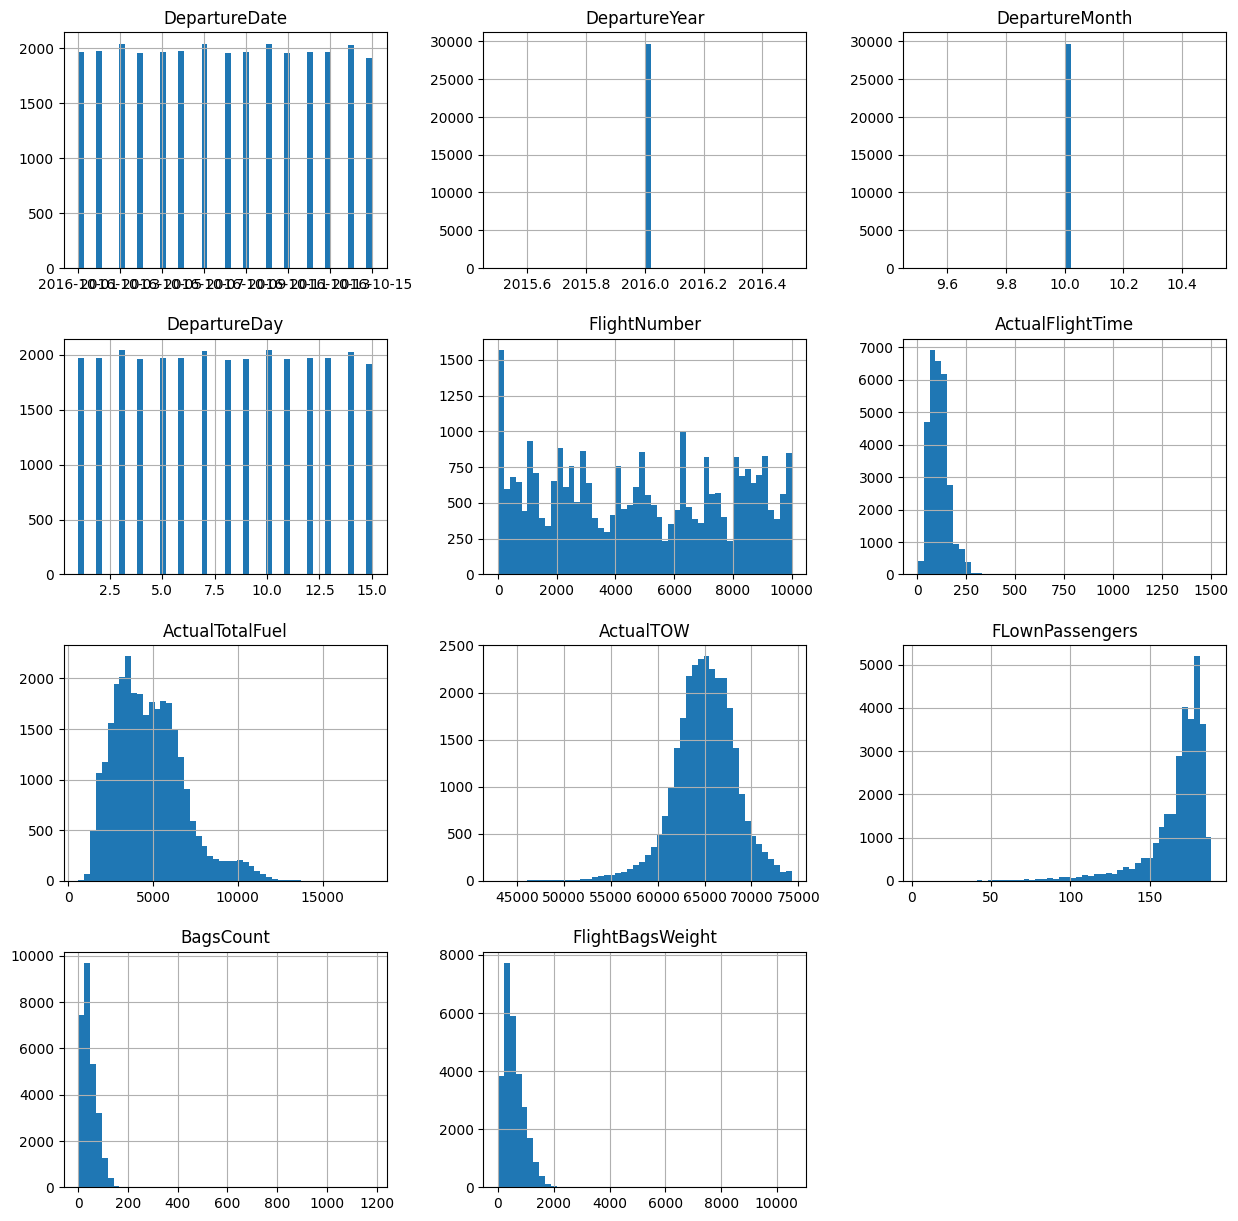

In [98]:
full_train_data.hist(figsize=(15,15), bins=50)
plt.show()

The figure above presents histograms of all numerical features in the training dataset. It allows us to assess the distribution and potential skewness of the variables.
- `ActualTOW` is approximately normally distributed with a clear peak around 65,000 kg

- `FlownPassengers` and `BagsCount` show right-skewed distributions, indicating that most flights carry a high number of passengers and bags, though some flights have significantly fewer.

- `ActualTotalFuel` is right-skewed as well, which is expected as shorter flights consume less fuel.

- `FlightNumber` and `ActualFlightTime` appear constant or contain a single mode, suggesting they may be either categorical or incorrectly typed.

- The feature `DepartureDay` shows even distribution across the 15 days in the dataset.


In [99]:
day_grouped = full_train_data.groupby(full_train_data["DepartureDate"].dt.day)["ActualTOW"].mean()

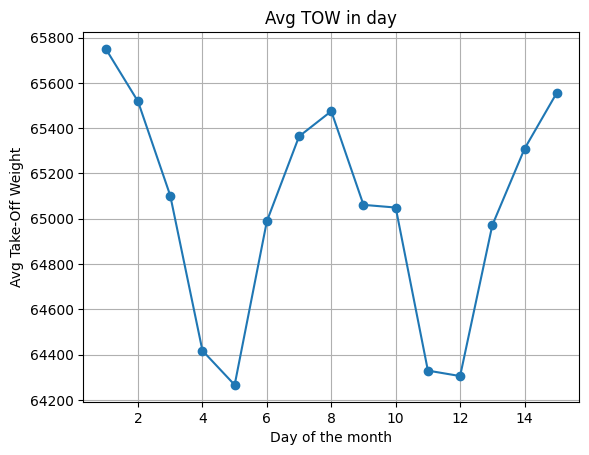

In [100]:
plt.plot(day_grouped,marker='o')
plt.xlabel("Day of the month")
plt.ylabel("Avg Take-Off Weight")
plt.title("Avg TOW in day")
plt.grid(True)
plt.show()

The line chart shows the average Take-Off Weight (TOW) for each day of the month between October 1st and October 15th.

- We observe periodic fluctuations in average TOW over the days.

- There is a clear drop in TOW around the 5th and 12th, with values going below 64,300 kg.

- Peaks are noticeable on the 1st, 2nd, 8th and 15th, exceeding 65,500 kg.

- This pattern may reflect changes in flight schedule intensity, passenger demand, or weekend effects.

Text(0.5, 1.0, 'Avg TOW in day')

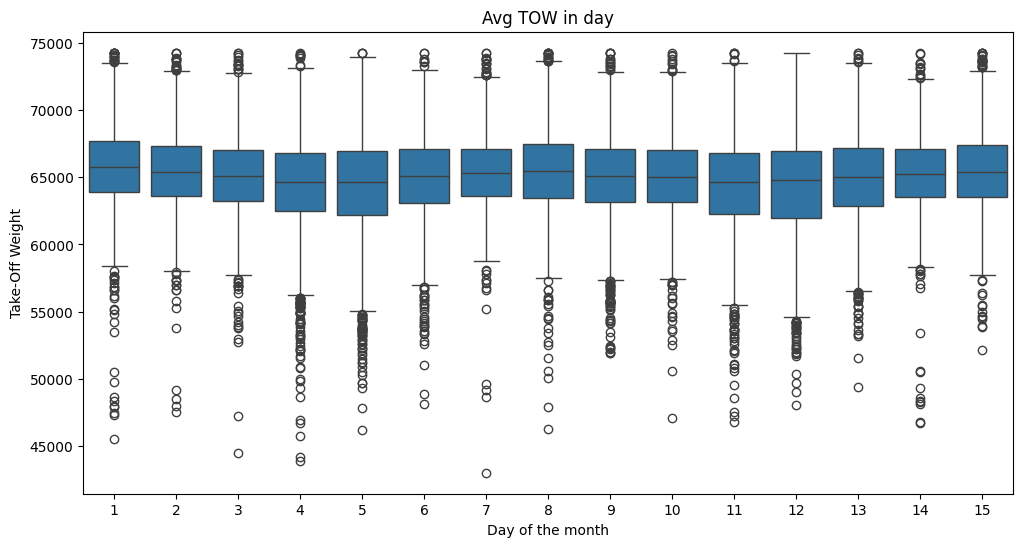

In [101]:
plt.figure(figsize=(12,6))
sns.boxplot(x=full_train_data["DepartureDate"].dt.day, y=full_train_data["ActualTOW"])
plt.xlabel("Day of the month")
plt.ylabel("Take-Off Weight")
plt.title("Avg TOW in day")

The boxplot displays the distribution of Take-Off Weight (TOW) across each day of the month from October 1st to 15th.

- The median TOW remains relatively stable across all days, around 65,000 kg.

- There is visible variability in interquartile ranges across some days — for example, day 5 and day 12 have slightly lower medians and tighter spreads.

- Outliers are present on both ends, especially lower-end outliers below 50,000 kg.

**This plot confirms that TOW does not drastically change across calendar days, although small fluctuations may still be relevant.**

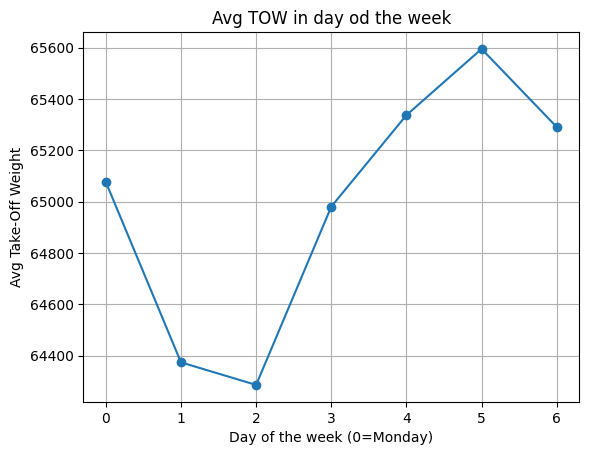

In [102]:
day_of_week_grouped = full_train_data.groupby(full_train_data["DepartureDate"].dt.dayofweek)["ActualTOW"].mean()
plt.plot(day_of_week_grouped,marker='o')
plt.xlabel("Day of the week (0=Monday)")
plt.ylabel("Avg Take-Off Weight")
plt.title("Avg TOW in day od the week")
plt.grid(True)
plt.show()

The line chart presents the average Take-Off Weight (TOW) by day of the week, where 0 corresponds to Monday and 6 to Sunday.

- There is a clear weekly pattern in TOW values.

- TOW is lowest on Tuesday (day 2) and gradually increases toward the weekend.

- The highest average TOW is observed on Saturday (day 5), suggesting that weekend flights tend to carry more passengers or luggage.

**This indicates that day of the week is a significant feature and should be included in the modeling process.**

Text(0.5, 1.0, 'TOW vs Day of the week')

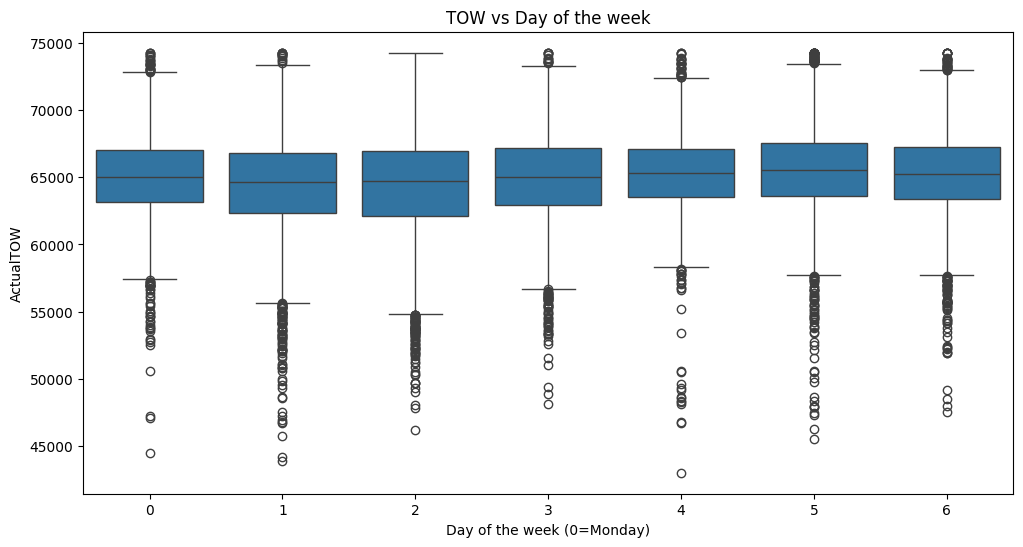

In [103]:
plt.figure(figsize=(12,6))
sns.boxplot(x=full_train_data["DepartureDate"].dt.dayofweek, y=full_train_data["ActualTOW"])
plt.xlabel("Day of the week (0=Monday)")
plt.title("TOW vs Day of the week")

The boxplot shows the distribution of Take-Off Weight (TOW) across each day of the week (0 = Monday).

- While median TOW values appear relatively stable throughout the week, Friday and Saturday (days 4 and 5) show slightly higher medians and more variability.

- Tuesday (day 2) exhibits the lowest median and a tighter distribution, aligning with the dip observed in the line plot of average TOW.

**This confirms that although daily differences are not extreme, weekly patterns in TOW exist and should be considered in modeling.**

Text(0.5, 1.0, 'Passengers per day of the week')

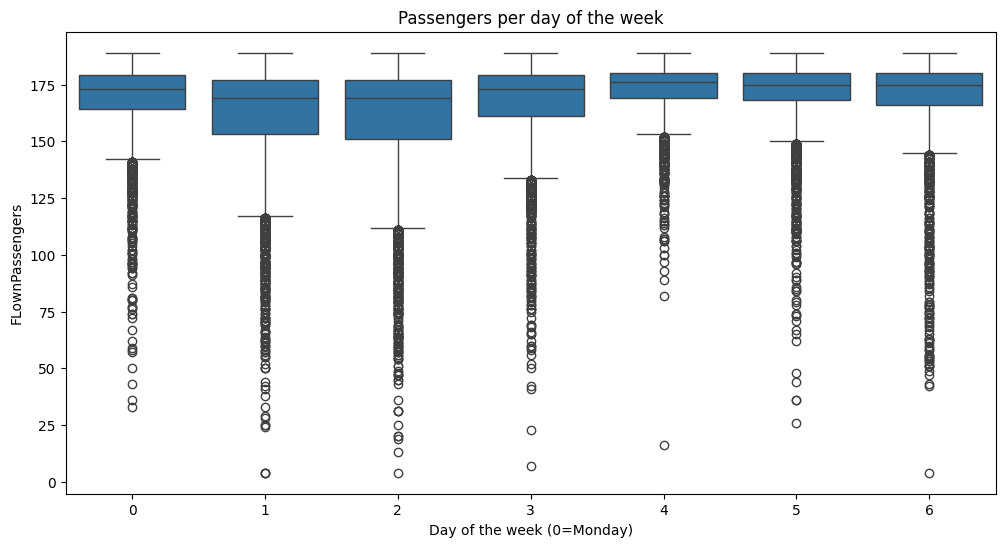

In [104]:
plt.figure(figsize=(12,6))
sns.boxplot(x=full_train_data["DepartureDate"].dt.dayofweek, y=full_train_data["FLownPassengers"])
plt.xlabel("Day of the week (0=Monday)")
plt.title("Passengers per day of the week")

The boxplot displays the distribution of `FlownPassengers` across days of the week (0 = Monday).

- The median number of passengers is consistently high across all days, typically above 170.

- However, Tuesday (day 1) and Wednesday (day 2) show a slightly lower median and wider  interquartile range, indicating passenger counts are more spread out on thoses days.

- This supports the earlier observation that Take-Off Weight is slightly lower on Tuesdays and Wednesdays, likely due to reduced passenger numbers.

Overall, passenger count correlates with day of the week, which in turn explains some of the variations in TOW.

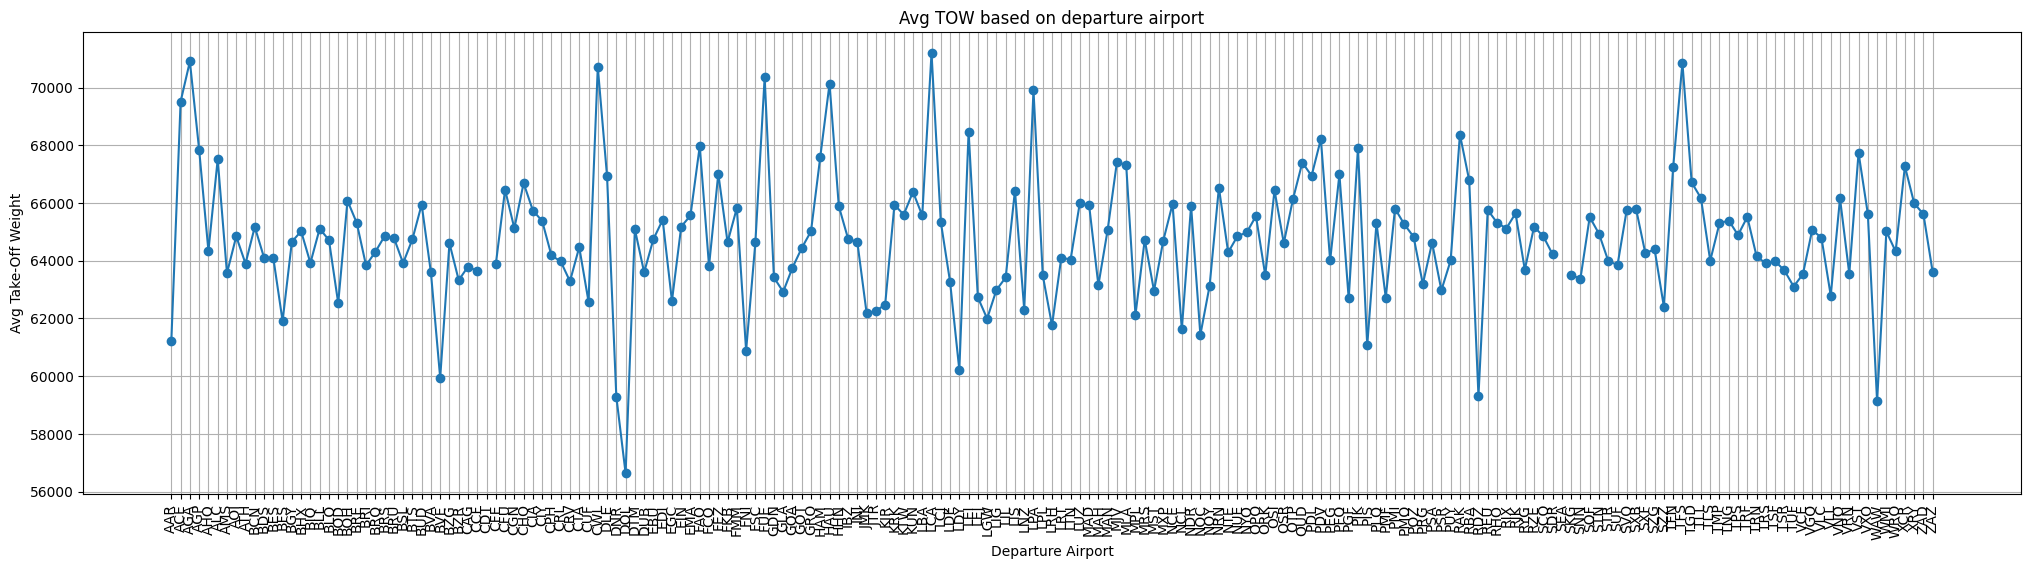

In [105]:
plt.figure(figsize=(25,6))
airport_start_grouped = full_train_data.groupby(full_train_data["DepartureAirport"])["ActualTOW"].mean()
plt.plot(airport_start_grouped,marker='o')
plt.xlabel("Departure Airport")
plt.ylabel("Avg Take-Off Weight")
plt.title("Avg TOW based on departure airport")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

The line chart presents the average Take-Off Weight (TOW) for each departure airport. Each point corresponds to one airport in the dataset.

- There is substantial variation in average TOW across departure airports, ranging roughly from below 60,000 kg to above 70,000 kg.

- Some airports (on the left side) exhibit consistently higher TOW, possibly due to longer or high-demand routes.

- Other airports show notably lower average TOW, which may reflect shorter flights, fewer passengers, or regional destinations.

**These differences suggest that departure airport is a meaningful predictor for TOW and should be included in the model.**

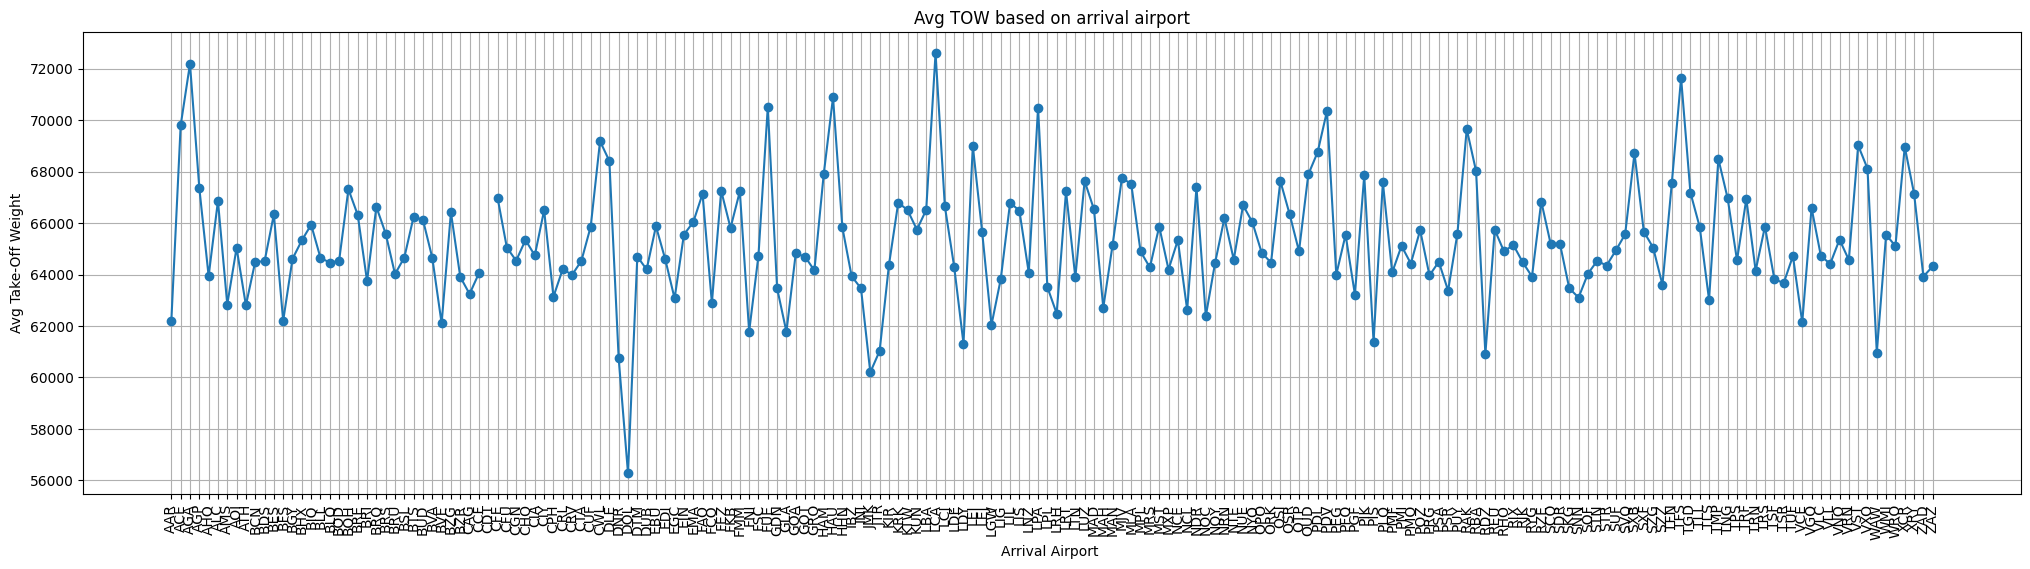

In [106]:
plt.figure(figsize=(25,6))
airport_finish_grouped = full_train_data.groupby(full_train_data["ArrivalAirport"])["ActualTOW"].mean()
plt.plot(airport_finish_grouped,marker='o')
plt.xlabel("Arrival Airport ")
plt.ylabel("Avg Take-Off Weight")
plt.title("Avg TOW based on arrival airport")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

The line plot displays the average Take-Off Weight (TOW) grouped by arrival airport.

- Similar to the departure airport analysis, there is notable variation in TOW depending on the destination.

- Certain arrival airports are associated with higher TOW values, likely due to longer flight distances that require more fuel and/or serve busier routes.

- Others show consistently lower average TOW, which may reflect short flights or low-demand routes.

**This suggests that arrival airport contains relevant information and can serve as a valuable feature for modeling.**

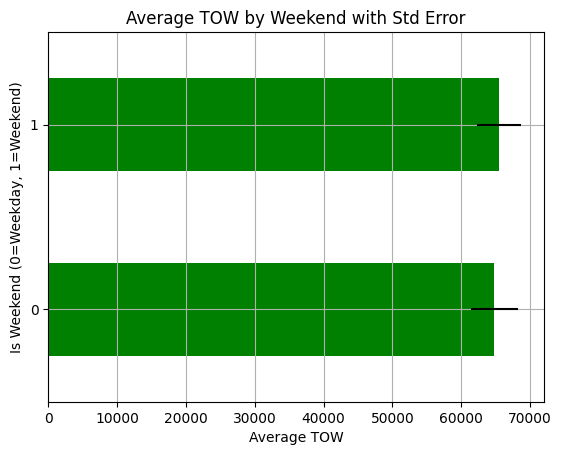

In [107]:
temp_data = full_train_data.copy()
temp_data["is_weekend"] = full_train_data['DepartureDate'].dt.dayofweek
temp_data["is_weekend"] = np.where(temp_data["is_weekend"] >= 5, 1, 0)

weekend_grouped = temp_data.groupby("is_weekend")["ActualTOW"].agg(["mean", "std"])

weekend_grouped.plot(kind="barh", y="mean", xerr="std", color="green", legend=False)
plt.xlabel("Average TOW")
plt.ylabel("Is Weekend (0=Weekday, 1=Weekend)")
plt.title("Average TOW by Weekend with Std Error")
plt.grid(True)
plt.show()


In [108]:
weekend_grouped

,mean,std
is_weekend,,
0,64814.357037,3414.318277
1,65471.689356,3136.137268


The horizontal bar plot illustrates the average Take-Off Weight (TOW) for flights on weekdays (is_weekend = 0) versus weekends (is_weekend = 1), including standard deviation as error bars.

- Flights during weekends tend to have slightly higher average TOW compared to weekdays.

- The difference is not dramatic, but consistent with earlier findings where weekend days showed higher TOW values.

- The error bars indicate that variability (std) is comparable in both groups, which suggests this trend is stable across the data.

**Overall, this supports the inclusion of is_weekend as a useful binary feature in the regression model.**

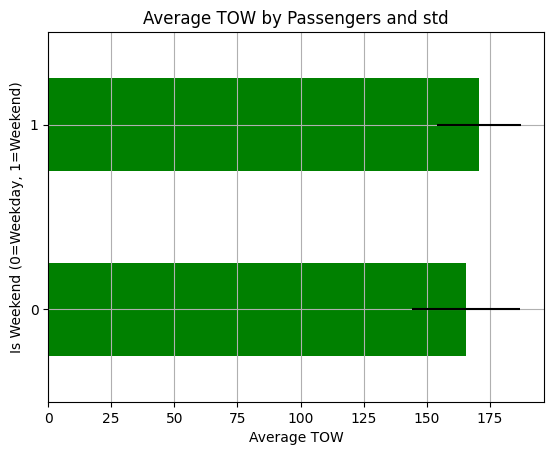

In [109]:
weekend_passengers_grouped = temp_data.groupby("is_weekend")["FLownPassengers"].agg(["mean", "std"])
weekend_passengers_grouped.plot(kind="barh", y="mean", xerr="std", color="green", legend=False)
plt.xlabel("Average TOW")
plt.ylabel("Is Weekend (0=Weekday, 1=Weekend)")
plt.title("Average TOW by Passengers and std")
plt.grid(True)
plt.show()


In [110]:
weekend_passengers_grouped

,mean,std
is_weekend,,
0,165.579847,21.564994
1,170.714095,16.471633


The chart illustrates the average number of passengers on weekdays (is_weekend = 0) versus weekends (is_weekend = 1), with standard deviation represented as error bars.

- On average, weekend flights carry more passengers (≈ 171) than weekday flights (≈ 166).

- The standard deviation is also slightly smaller on weekends, indicating more consistent occupancy levels.

- This supports the earlier observation that weekend flights tend to have higher Take-Off Weight, likely driven by higher passenger loads.

**Therefore, the feature is_weekend may serve as an indirect signal for passenger volume and should be retained in the mode**l.

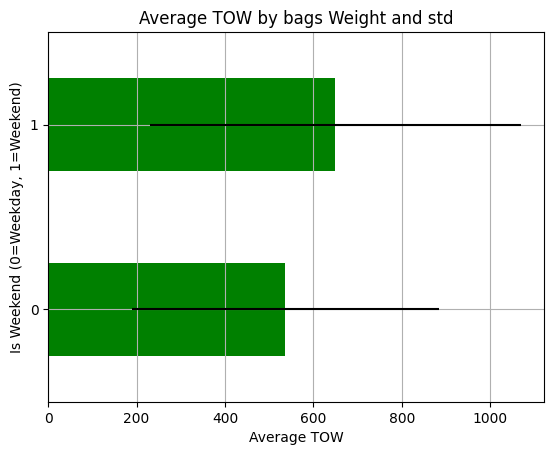

In [111]:
weekend_bags_grouped = temp_data.groupby("is_weekend")["FlightBagsWeight"].agg(["mean", "std"])
weekend_bags_grouped.plot(kind="barh", y="mean", xerr="std", color="green", legend=False)
plt.xlabel("Average TOW")
plt.ylabel("Is Weekend (0=Weekday, 1=Weekend)")
plt.title("Average TOW by bags Weight and std")
plt.grid(True)
plt.show()


In [112]:
weekend_bags_grouped

,mean,std
is_weekend,,
0,536.366579,347.730785
1,649.232129,419.026537


The chart presents the average `FlightBagsWeight` by weekend , with error bars indicating standard deviation.

- Weekend flights (is_weekend = 1) carry on average more baggage weight (≈ 649 kg) compared to weekday flights (≈ 536 kg).

- The standard deviation is also higher on weekends, suggesting greater variability in how much baggage is transported.

- This supports the hypothesis that weekend flights tend to be heavier overall, contributing to higher Take-Off Weight.

**Including is_weekend as a binary feature may help the model capture patterns in passenger and baggage behavior.**

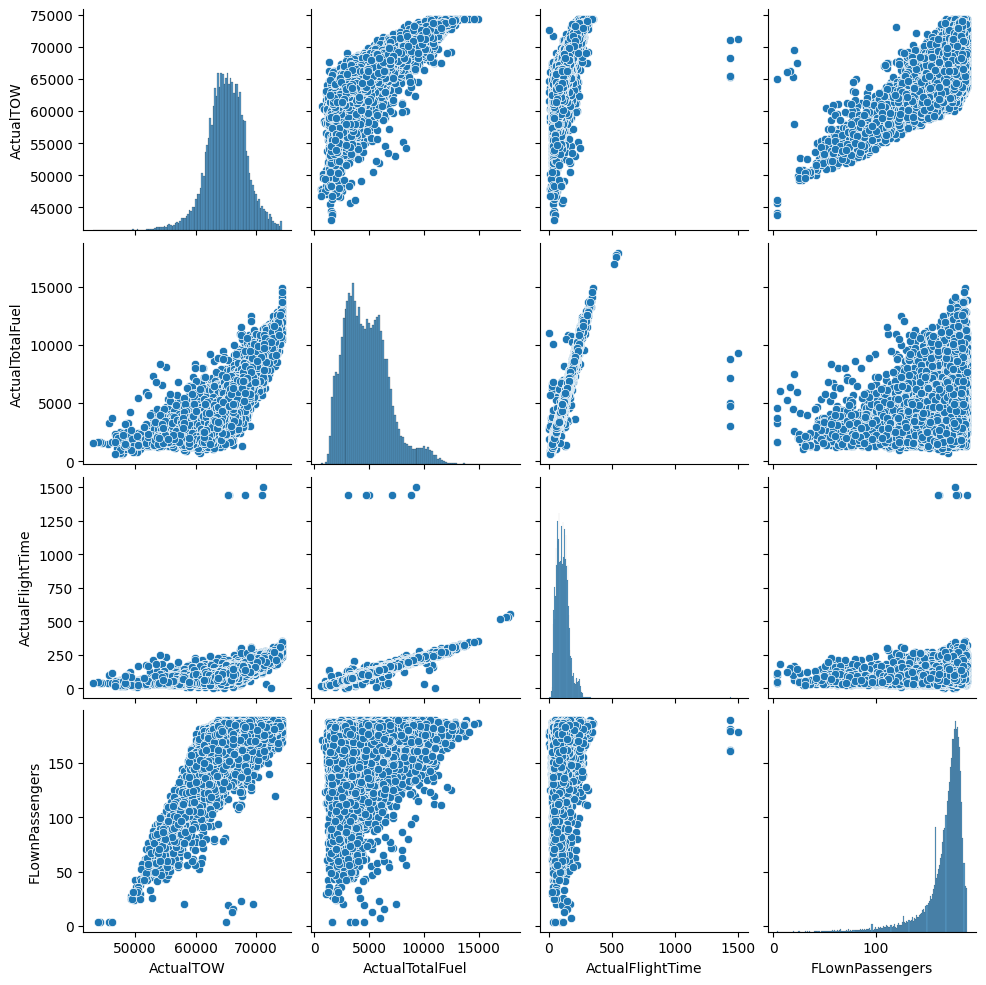

In [113]:
sns.pairplot(full_train_data[["ActualTOW", "ActualTotalFuel", "ActualFlightTime", "FLownPassengers"]])


The pairplot above displays scatterplots and histograms for key numerical features: `ActualTOW`, `ActualTotalFuel`, `ActualFlightTime`, and `FlownPassengers`.

ActualTOW shows strong positive correlation with ActualTotalFuel – heavier aircraft tend to carry more fuel.

There is also a  positive relationship between ActualTOW and FlownPassengers, as more passengers generally contribute to a heavier take-off weight.

ActualFlightTime exhibits a weaker and more dispersed relationship with other variables, though it shows some trend with fuel consumption.

All distributions are right-skewed, but ActualTOW itself appears roughly normally distributed, which is useful for modeling.

<Axes: >

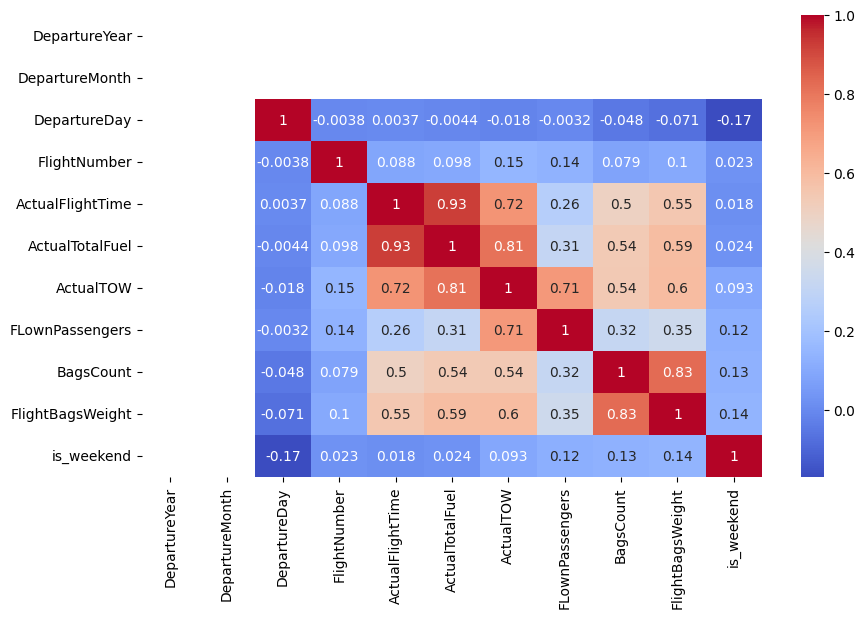

In [114]:
plt.subplots(figsize=(10,6))
sns.heatmap(temp_data.corr(numeric_only=True), annot=True, cmap="coolwarm")
# There are not much NaN vales so i will create this plot right now

<Axes: xlabel='ActualTOW', ylabel='Count'>

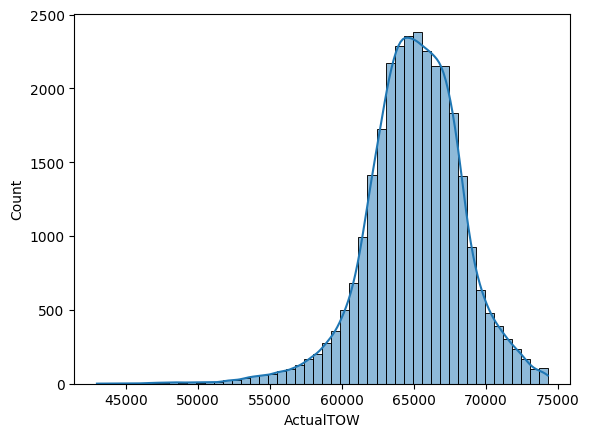

In [115]:
sns.histplot(full_train_data["ActualTOW"], bins=50, kde=True)


<Axes: xlabel='ActualFlightTime', ylabel='Count'>

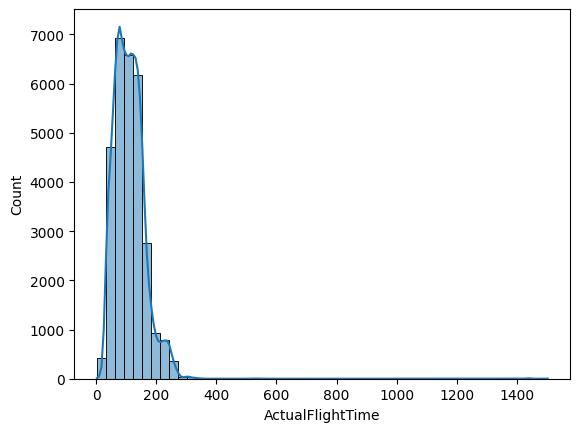

In [116]:
sns.histplot(full_train_data["ActualFlightTime"], bins=50, kde=True)


<Axes: xlabel='ActualTotalFuel', ylabel='Count'>

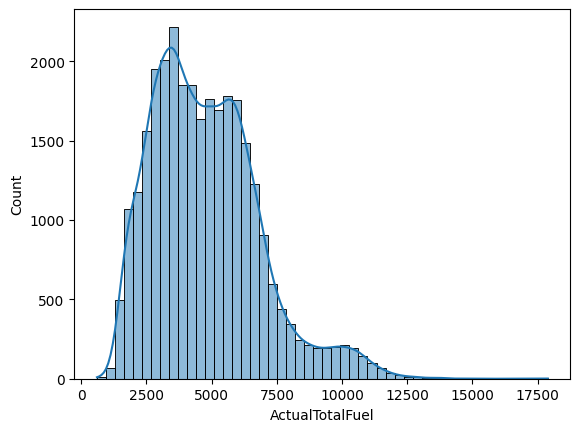

In [117]:
sns.histplot(full_train_data["ActualTotalFuel"], bins=50, kde=True)


<Axes: xlabel='FLownPassengers', ylabel='Count'>

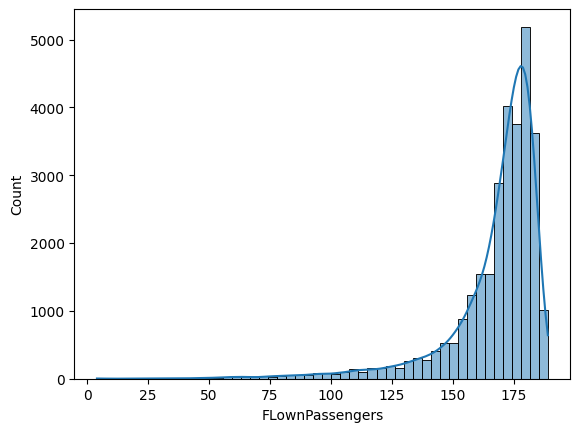

In [118]:
sns.histplot(full_train_data["FLownPassengers"], bins=50, kde=True)


<Axes: xlabel='BagsCount', ylabel='Count'>

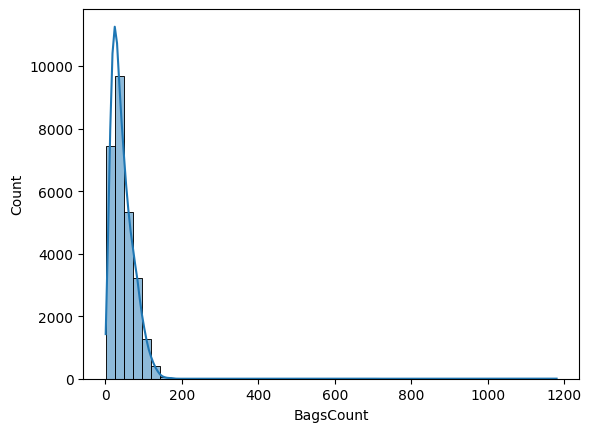

In [119]:
sns.histplot(full_train_data["BagsCount"], bins=50, kde=True)


<Axes: xlabel='FlightBagsWeight', ylabel='Count'>

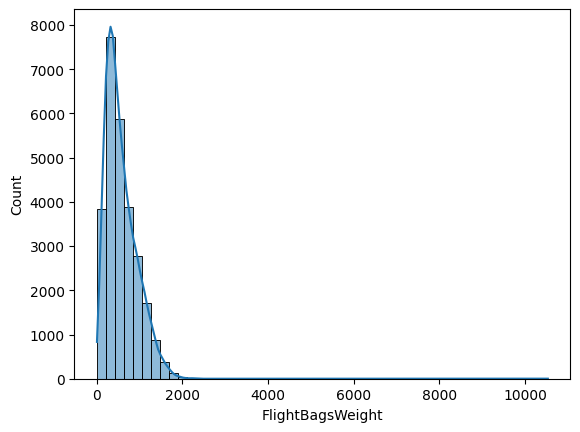

In [120]:
sns.histplot(full_train_data["FlightBagsWeight"], bins=50, kde=True)


## Feature Engineering and Data Preprocessing

In [121]:
train_data = full_train_data.copy()
# Working on copy of the data set

In [122]:
# % of null values
for var in train_data:
  if train_data[var].isna().sum()>0:
    print(var,train_data[var].isna().mean())

ActualTOW 0.014563923177827856
FLownPassengers 0.00319531801823013
BagsCount 0.07682217214355387
FlightBagsWeight 0.08334734788604486


In [123]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29731 entries, 0 to 29730
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DepartureDate     29731 non-null  datetime64[ns]
 1   DepartureYear     29731 non-null  int64         
 2   DepartureMonth    29731 non-null  int64         
 3   DepartureDay      29731 non-null  int64         
 4   FlightNumber      29731 non-null  int64         
 5   DepartureAirport  29731 non-null  object        
 6   ArrivalAirport    29731 non-null  object        
 7   Route             29731 non-null  object        
 8   ActualFlightTime  29731 non-null  int64         
 9   ActualTotalFuel   29731 non-null  int64         
 10  ActualTOW         29298 non-null  float64       
 11  FLownPassengers   29636 non-null  float64       
 12  BagsCount         27447 non-null  float64       
 13  FlightBagsWeight  27253 non-null  float64       
dtypes: datetime64[ns](1), 

In [124]:
# make a list of the numerical and categorical variables first
numerical = [var for var in train_data.columns if train_data[var].dtype!='O']
categorical = [var for var in train_data.columns if train_data[var].dtype=='O']

In [125]:
categorical

['DepartureAirport', 'ArrivalAirport', 'Route']

In [126]:
numerical

['DepartureDate',
 'DepartureYear',
 'DepartureMonth',
 'DepartureDay',
 'FlightNumber',
 'ActualFlightTime',
 'ActualTotalFuel',
 'ActualTOW',
 'FLownPassengers',
 'BagsCount',
 'FlightBagsWeight']

In [127]:
train_data

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,2016-10-01,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,2016-10-01,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0
2,2016-10-01,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN
3,2016-10-01,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0
4,2016-10-01,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,2016-10-15,2016,10,15,9833,PMI,HHN,PMI-HHN,102,4880,66247.0,177.0,96.0,1250.0
29727,2016-10-15,2016,10,15,9862,LPL,AGP,LPL-AGP,163,6890,67898.0,185.0,107.0,1390.0
29728,2016-10-15,2016,10,15,9863,AGP,LPL,AGP-LPL,145,6322,66247.0,172.0,64.0,830.0
29729,2016-10-15,2016,10,15,9948,FAO,ORK,FAO-ORK,132,5880,68224.0,183.0,82.0,1090.0


In [128]:
for var in categorical:
  print(var, len(train_data[var].unique()))

DepartureAirport 191
ArrivalAirport 190
Route 2667


In [129]:
route_freq = train_data["Route"].value_counts(normalize=True)
route_freq

,proportion
Route,
DUB-STN,0.004070
STN-DUB,0.004036
DUB-LGW,0.003532
ATH-SKG,0.003532
SKG-ATH,0.003532
...,...
NYO-FCO,0.000034
FCO-CGN,0.000034
FCO-CAG,0.000034


In [130]:
start_airport_freq = train_data["DepartureAirport"].value_counts(normalize=True)
start_airport_freq

,proportion
DepartureAirport,
STN,0.086240
DUB,0.054623
BGY,0.038882
BCN,0.029868
CRL,0.025697
...,...
LCA,0.000135
DOL,0.000135
RJK,0.000135


In [131]:
end_airport_freq = train_data["ArrivalAirport"].value_counts(normalize=True)
end_airport_freq

,proportion
ArrivalAirport,
STN,0.086341
DUB,0.054758
BGY,0.039017
BCN,0.029834
CRL,0.025697
...,...
OSI,0.000135
RDZ,0.000135
LCA,0.000135


In [132]:
train_data

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,2016-10-01,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,2016-10-01,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0
2,2016-10-01,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN
3,2016-10-01,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0
4,2016-10-01,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,2016-10-15,2016,10,15,9833,PMI,HHN,PMI-HHN,102,4880,66247.0,177.0,96.0,1250.0
29727,2016-10-15,2016,10,15,9862,LPL,AGP,LPL-AGP,163,6890,67898.0,185.0,107.0,1390.0
29728,2016-10-15,2016,10,15,9863,AGP,LPL,AGP-LPL,145,6322,66247.0,172.0,64.0,830.0
29729,2016-10-15,2016,10,15,9948,FAO,ORK,FAO-ORK,132,5880,68224.0,183.0,82.0,1090.0


## Data preprocessing steps
1. NaN
- Remove rows when `ActualTOW` has null value. We want to predict it not, impute it
- To the rest of features with null imput with mean and add bianry `is_missing` column
2. DataTime
- Remove `DepartureDate`	and `DepartureYear` columns.
- Create binary column `is_weekned`
- Leave columns `DepartureMonth` and `DepartureDay`. They may have some predictive power or at lease may present some sesional changes in the future
3. Deleate `FlightNumber`
4. Categorical columns
Categorical columns like `['DepartureAirport', 'ArrivalAirport', 'Route']` are highly cardinal, expecially `Route`. but i strongly belive it may have some predictive power. Using OHE will result in diementinality explotion, and laber Encoding will create some irrelevatn order therefore:
- columns 'DepartureAirport', 'ArrivalAirport' will be encoded with Frequency Encoding but first to reduce cardinality I will use Rare Label Encoding
- column `Route` hase the biggest cardinality. So the first step will be to use Rare Label Encoding and then Target Encoding.
4. Sclaing Features
- Numerical Features will be scaled with Yeo-Johnson transformation

## Modeling Plan
1. using Stacking Regressor to crate more robust models and better predictions. Models to use: RF, XGBoost, CatBoost, Linear Regression



In [133]:
# Create is_weekned feature
def create_is_weekend(df):
  df["is_weekend"] = df['DepartureDate'].dt.dayofweek
  df["is_weekend"] = np.where(df["is_weekend"] >= 5, 1, 0)
  return df

In [134]:
def create_day_of_week(df):
  df["day_of_week"] = df['DepartureDate'].dt.dayofweek
  return df

In [135]:
# drop features
def drop_some_features(df):
  return df.drop(columns=["DepartureYear","DepartureDate","FlightNumber"])

In [136]:
# del instances where ActualTOW is null
def del_null_in_target(df):
  df.dropna(subset=["ActualTOW"], inplace=True)
  return df

Whole pre-processing steps

In [137]:
train_data = pd.read_csv("/content/drive/MyDrive/Ryanair/training.csv",sep="\t")
train_data

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016,175,61,440
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138,182,27,350
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447,127,(null),(null)
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587,163,12,150
4,01/10/2016,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090,178,37,490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,15/10/2016,2016,10,15,9833,PMI,HHN,PMI-HHN,102,4880,66247,177,96,1250
29727,15/10/2016,2016,10,15,9862,LPL,AGP,LPL-AGP,163,6890,67898,185,107,1390
29728,15/10/2016,2016,10,15,9863,AGP,LPL,AGP-LPL,145,6322,66247,172,64,830
29729,15/10/2016,2016,10,15,9948,FAO,ORK,FAO-ORK,132,5880,68224,183,82,1090


In [138]:
def clean_data(df):
  cols_to_clean = ['ActualTOW', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']

  for col in cols_to_clean:
    df[col] = df[col].astype(str).str.strip()

  for col in cols_to_clean:
    df[col] = df[col].replace("(null)",np.nan)
    df[col] = df[col].astype(float)
  return df

In [139]:
train_data = clean_data(train_data)
train_data["DepartureDate"] = pd.to_datetime(train_data["DepartureDate"], format="%d/%m/%Y")
train_data = create_is_weekend(train_data)
train_data = create_day_of_week(train_data)
train_data = del_null_in_target(train_data)
train_data = drop_some_features(train_data)
train_data


,DepartureMonth,DepartureDay,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight,is_weekend,day_of_week
0,10,1,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0,1,5
1,10,1,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0,1,5
2,10,1,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN,1,5
3,10,1,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0,1,5
4,10,1,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,10,15,PMI,HHN,PMI-HHN,102,4880,66247.0,177.0,96.0,1250.0,1,5
29727,10,15,LPL,AGP,LPL-AGP,163,6890,67898.0,185.0,107.0,1390.0,1,5
29728,10,15,AGP,LPL,AGP-LPL,145,6322,66247.0,172.0,64.0,830.0,1,5
29729,10,15,FAO,ORK,FAO-ORK,132,5880,68224.0,183.0,82.0,1090.0,1,5


In [140]:
X = train_data.drop("ActualTOW",axis=1)
y = train_data["ActualTOW"]

In [141]:

num_cols = ["FLownPassengers", "BagsCount", "FlightBagsWeight","ActualTotalFuel","ActualFlightTime"]
cat_airports = ["DepartureAirport", "ArrivalAirport"]
cat_route = ["Route"]
passthrough_cols = ["is_weekend",	"day_of_week"]


# Ability to use Feature Engine with Sklearn transformers
power_transform = SklearnTransformerWrapper(
    transformer=PowerTransformer(method="yeo-johnson", standardize=False),
    variables=num_cols
)

scaling = SklearnTransformerWrapper(
    transformer=StandardScaler(),
    variables=num_cols
)

# Stacking Regressor
estimators = [
    ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ("gb", GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ("xgb", XGBRegressor(random_state=42)),
    ("lasso",Lasso())
]

final_estimator = Ridge(alpha=1.0, random_state=42)

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    passthrough=True,
    n_jobs=-1
)

new_pipeline = Pipeline(steps=[
    ("add_missing_indicator", AddMissingIndicator(variables=num_cols)),
    ("median_imputation", MeanMedianImputer(imputation_method="median", variables=num_cols)),
    ("rare_airport", RareLabelEncoder(tol=0.01,variables=cat_airports)),
    ("rare_route", RareLabelEncoder(tol=0.001, variables=cat_route)), # less than 0.1% is consider RARE category
    ("freq", CountFrequencyEncoder(encoding_method="frequency", variables=cat_airports)),
    ("mean", MeanEncoder(variables=cat_route)),
    ("power", power_transform),
    ("scaler", scaling),
    ("model", stacking_model)
])

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmses_val = []
rmses_train= []

for train_index, val_index in tscv.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    new_pipeline.fit(X_train, y_train)

    y_val_pred = new_pipeline.predict(X_val)
    y_train_pred = new_pipeline.predict(X_train)


    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    rmse_train = root_mean_squared_error(y_train, y_train_pred)

    print(f"Fold VAL RMSE: {rmse_val:.2f}")
    rmses_val.append(rmse_val)
    print(f"Fold TRAIN RMSE: {rmse_train:.2f}")
    rmses_train.append(rmse_train)

    print("==================")

# Results
avg_rmse_val = np.mean(rmses_val)
std_rmse_val = np.std(rmses_val)

avg_rmse_train = np.mean(rmses_train)
std_rmse_train = np.std(rmses_train)

print(f"Avg rmse val: {avg_rmse_val},  std rmse val: {std_rmse_val}")
print(f"Avg rmse train: {avg_rmse_train},  std rmse train: {std_rmse_train}")





Fold VAL RMSE: 1045.13
Fold TRAIN RMSE: 567.64
Fold VAL RMSE: 864.15
Fold TRAIN RMSE: 660.62
Fold VAL RMSE: 862.93
Fold TRAIN RMSE: 627.80
Fold VAL RMSE: 883.92
Fold TRAIN RMSE: 626.23
Fold VAL RMSE: 870.32
Fold TRAIN RMSE: 663.19
Avg rmse val: 905.2889118165276,  std rmse val: 70.31473514800794
Avg rmse train: 629.0945683186558,  std rmse train: 34.47683587216825


# Prediction

In [142]:
new_pipeline.fit(X,y)

Pipeline(steps=[('add_missing_indicator',
                 AddMissingIndicator(variables=['FLownPassengers', 'BagsCount',
                                                'FlightBagsWeight',
                                                'ActualTotalFuel',
                                                'ActualFlightTime'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['FLownPassengers', 'BagsCount',
                                              'FlightBagsWeight',
                                              'ActualTotalFuel',
                                              'ActualFlightTime'])),
                ('rare_airport',
                 RareLabelEncoder(tol=0.01,
                                  variable...
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('lasso', Lasso())],
                                   final_estimator=Ridge(random_state=42),
                                   n_jobs=-1, passthrough=True))])

In [143]:
val_data = pd.read_csv("/content/drive/MyDrive/Ryanair/validation.csv",sep="\t")

In [144]:
def clean_data_val(df):
  cols_to_clean = ['FLownPassengers', 'BagsCount', 'FlightBagsWeight']

  for col in cols_to_clean:
    df[col] = df[col].astype(str).str.strip()

  for col in cols_to_clean:
    df[col] = df[col].replace("(null)",np.nan)
    df[col] = df[col].astype(float)
  return df

al_data = clean_data_val(val_data)
val_data["DepartureDate"] = pd.to_datetime(val_data["DepartureDate"], format="%d/%m/%Y")
val_data = create_is_weekend(val_data)
val_data = create_day_of_week(val_data)
val_data = drop_some_features(val_data)
val_data

,DepartureMonth,DepartureDay,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,is_weekend,day_of_week
0,11,1,MRS,BES,MRS-BES,84,3630,185.0,43.0,560.0,0,1
1,11,1,BES,MRS,BES-MRS,86,3690,188.0,NaN,NaN,0,1
2,11,1,MRS,STN,MRS-STN,100,4390,168.0,55.0,720.0,0,1
3,11,1,STN,MRS,STN-MRS,100,4690,185.0,35.0,460.0,0,1
4,11,1,STN,REU,STN-REU,112,4900,167.0,31.0,400.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1873,11,1,PMI,MAD,PMI-MAD,60,2775,173.0,12.0,160.0,0,1
1874,11,1,BLQ,VLC,BLQ-VLC,99,4120,183.0,21.0,270.0,0,1
1875,11,1,VLC,BLQ,VLC-BLQ,104,4230,182.0,31.0,400.0,0,1
1876,11,1,BRI,BLQ,BRI-BLQ,59,2671,169.0,10.0,130.0,0,1


In [145]:
y_predictions = new_pipeline.predict(val_data)

In [146]:
y_predictions

array([65328.39444813, 65802.9535675 , 64792.55042724, ...,
       65202.5045272 , 62447.59342262, 62851.15853439])

In [147]:
pd.DataFrame({"PredictedTOW": y_predictions}).to_csv("submission_ryanair_jan_dyndor.csv", index=False)

# Next steps


Unfortunately, the process of  tuning the hyperparameters of the models is quite time-consuming. However, it would naturally be the next step to optimize performance. Given more time and computational resources, the logical progression would be as follows:

- Tune the hyperparameters of the individual models within the stacking ensemble (e.g., RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, Lasso).
- Evaluate the performance of the tuned stacking ensemble using robust cross-validation techniques (like TimeSeriesSplit, given the temporal nature of the data) to identify the optimal configuration.
- Once the best set of hyperparameters is identified, train the final stacking model on the entire available training dataset.
- Finally, utilize the trained model to generate predictions on the provided validation dataset.

In [148]:
# param_grid = {
#     'model__rf__n_estimators': randint(100, 300),
#     'model__rf__max_depth': randint(5, 15),
#     'model__gb__learning_rate': uniform(0.01, 0.1),
#     'model__gb__max_depth': randint(3, 10),
#     'model__xgb__n_estimators': randint(100, 300),
#     'model__xgb__max_depth': randint(3, 10),
#     'model__final_estimator__alpha': uniform(0.1, 5)
# }

# search = RandomizedSearchCV(
#     new_pipeline,
#     param_distributions=param_grid,
#     n_iter=15,
#     cv=TimeSeriesSplit(n_splits=2),
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

# search.fit(X, y)

# print("Best RMSE:", -search.best_score_)
# print("Best params:", search.best_params_)
# best_model = search.best_estimator_
# best_params = best_params_

In [149]:
# tcv = TimeSeriesSplit(n_splits=5)
# def evaluate_model(pipeline, X,y,tcv):
#   rmse_val_list = []
#   rmse_train_list = []

#   for train_index, val_index in tcv.split(X,y):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train , y_val = y.iloc[train_index], y.iloc[val_index]

#     pipeline.fit(X_train,y_train)

#     y_preds_val = pipeline.predict(X_val)
#     y_preds_train = pipeline.predict(X_train)

#     rmse_val = root_mean_squared_error(y_val, y_preds_val)
#     rmse_train= root_mean_squared_error(y_train, y_preds_train)

#     rmse_val_list.append(rmse_val)
#     rmse_train_list.append(rmse_train)

#     return np.mean(rmse_val_list), np.mean(rmse_train_list)


In [150]:
# rmse_base_mean_val, rmse_base_mean_train = evaluate_model(new_pipeline, X, y, tcv)
# rmse_tuned_mean_val, rmse_tuned_mean_train = evaluate_model(search.best_estimator_, X, y, tcv)

# print(f"BASE pipeline RMSE VAL: {rmse_base_mean_val:.2f} ,  RMSE TRAIN {rmse_base_mean_train:.2f}")
# print(f"TUNED pipeline RMSE VAL: {rmse_tuned_mean_val:.2f} , RMSE TRAIN {rmse_tuned_mean_train:.2f}")
